In [1]:
import os
os.chdir('../')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from datasets.cityscapes import Cityscapes
from datasets.bdd100k import BDD100KSeg
from datasets.road_anomaly import RoadAnomaly
from datasets.fishyscapes import FishyscapesLAF, FishyscapesStatic
from datasets.segment_me_if_you_can import RoadAnomaly21, RoadObstacle21
from easydict import EasyDict as edict
from torch.utils.data import DataLoader
from torchmetrics import JaccardIndex

from tqdm.notebook import tqdm

from train_net import Trainer, setup
from detectron2.checkpoint import DetectionCheckpointer


from analysis.max_logits import MaxLogitsAnalyzer, OODEvaluator

# Paths

Here subscript $bi$ refers to the $i^{th}$ checkpoint before the last. This means that b1 is the checkpoint that was saved right before the final one was saved and so on. A checkpoint is saved every 5000 iterations.

In [4]:
config_path = 'model_logs/mask2former_swin_b_replication/config.yaml'
ckpt_path = 'model_logs/mask2former_swin_b_replication/model_final.pth'
ckpt_path_b1 = 'model_logs/mask2former_swin_b_replication/model_0084999.pth'
ckpt_path_b2 = 'model_logs/mask2former_swin_b_replication/model_0079999.pth'

ckpt_paths = {
    'final': ckpt_path,
    'b1': ckpt_path_b1,
    'b2': ckpt_path_b2,
}


# Loading the Model

In [5]:
def load_model_state_dict(path):
    with open(path, 'rb') as f:
        state_dict = pickle.load(f)
    
    return state_dict['model']

def get_model(name='final'):
    
    args = edict({'config_file': config_path, 'eval-only':True, 'opts':[]})
    config = setup(args)

    model = Trainer.build_model(config)
    DetectionCheckpointer(model, save_dir=config.OUTPUT_DIR).resume_or_load(
        ckpt_paths[name], resume=False
    )
    model.cuda()
    _ = model.eval()
    
    return model


In [6]:
model = get_model('final')

[09/01 13:05:57 detectron2]: Rank of current process: 0. World size: 1
[09/01 13:05:58 detectron2]: Environment info:
----------------------  -----------------------------------------------------------------------------------------------------------------
sys.platform            linux
Python                  3.8.13 (default, Mar 28 2022, 11:38:47) [GCC 7.5.0]
numpy                   1.23.2
detectron2              0.6 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/detectron2
Compiler                GCC 7.3
CUDA compiler           CUDA 11.1
detectron2 arch flags   /home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/detectron2/_C.cpython-38-x86_64-linux-gnu.so
DETECTRON2_ENV_MODULE   <not set>
PyTorch                 1.9.0+cu111 @/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/torch
PyTorch debug build     False
GPU available           Yes
GPU 0                   NVIDIA GeForce RTX 3090 (arch=8.6)
Driver version          510.85.

[09/01 13:05:58 detectron2]: Running with full config:
CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST:
  - cityscapes_fine_sem_seg_val
  TRAIN:
  - cityscapes_fine_sem_seg_train
GLOBAL:
  HACK: 1.0
INPUT:
  COLOR_AUG_SSD: true
  CROP:
    ENABLED: true
    SINGLE_CATEGORY_MAX_AREA: 1.0
    SIZE:
    - 512
    - 1024
    TYPE: absolute
  DATASET_MAPPER_NAME: mask_former_semantic
  FORMAT: RGB
  IMAGE_SIZE: 1024
  MASK_FORMAT: polygon
  MAX_SCALE: 2.0
  MAX_SIZE_TEST: 2048
  MAX_SIZE_TRAIN: 4096
  MIN_SCALE: 0.1
  MIN_SIZE_TEST: 1024
  MIN_SIZE_TRAIN:
  - 512
  - 614
  - 716
  - 819
  - 921
  - 1024
  - 1126
  - 1228
  - 1331
  - 1433
  - 1536
  - 1638
  - 1740
  - 1843
  - 1945
  - 2048
  MIN_SIZE_TRAIN_SAMPLING: choi

[09/01 13:05:58 detectron2]: Full config saved to ./output/config.yaml
[09/01 13:05:58 d2.utils.env]: Using a generated random seed 58951854
[09/01 13:06:01 d2.engine.defaults]: Model:
SemanticSegmentor(
  (backbone): D2SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
  

[09/01 13:06:01 fvcore.common.checkpoint]: [Checkpointer] Loading from model_logs/mask2former_swin_b_replication/model_final.pth ...
WARNING [09/01 13:06:01 fvcore.common.checkpoint]: Skip loading parameter 'sem_seg_head.predictor.query_feat.weight' to the model due to incompatible shapes: (100, 256) in the checkpoint but (19, 256) in the model! You might want to double check if this is expected.
WARNING [09/01 13:06:01 fvcore.common.checkpoint]: Skip loading parameter 'sem_seg_head.predictor.query_embed.weight' to the model due to incompatible shapes: (100, 256) in the checkpoint but (19, 256) in the model! You might want to double check if this is expected.
WARNING [09/01 13:06:01 fvcore.common.checkpoint]: Some model parameters or buffers are not found in the checkpoint:
sem_seg_head.predictor.query_embed.weight
sem_seg_head.predictor.query_feat.weight
WARNING [09/01 13:06:01 fvcore.common.checkpoint]: The checkpoint state_dict contains keys that are not used by the model:
  criteri

# Dataset Configs

In [7]:
bdd100k_config = edict({
    'seg_downsample_rate': 1,
    'train_file': 'train_paths.txt',
    'val_file': 'val_paths.txt',
    'val_image_strategy': 'no_change',
    'ignore_train_class': True,
    'dataset_root': '/home/user/datasets/bdd100k/seg'
})

cityscapes_config = edict({
    'dataset_root': '/home/user/datasets/cityscapes',
})

road_anomaly_config = edict({
    'dataset_root': '/home/user/datasets/RoadAnomaly/RoadAnomaly_jpg',
    'test_image_strategy': 'no_change'
})

fishyscapes_laf_config = edict({
    'dataset_root': '/home/user/datasets/Fishyscapes/',
})

fishyscapes_static_config = edict({
    'dataset_root': '/home/user/datasets/Fishyscapes/',
})

road_anomaly_21_config = edict({
    'dataset_root': '/home/user/datasets/SegmentMeIfYouCan/dataset_AnomalyTrack',
    'dataset_mode': 'all'
})

road_obstacle_21_config = edict({
    'dataset_root': '/home/user/datasets/SegmentMeIfYouCan/dataset_ObstacleTrack',
    'dataset_mode': 'all'
})



# Create Datasets

In [8]:
# Cityscapes
transform = A.Compose([
    ToTensorV2()
])
cityscapes_dataset = Cityscapes(cityscapes_config, transform=transform, split='val', 
                                target_type='semantic')
loader_cityscapes = DataLoader(cityscapes_dataset, batch_size=1, shuffle=False, num_workers=15)

# BDD100K
transform_bdd100k = A.Compose([
    ToTensorV2(),
])
bdd100k_dataset = BDD100KSeg(hparams=bdd100k_config, mode='val', transforms=transform_bdd100k, 
                             image_size=(720, 1280))
loader_bdd100k = DataLoader(bdd100k_dataset, batch_size=1, shuffle=False, num_workers=15)
# Road Anomaly
transform_road_anomaly = A.Compose([
    ToTensorV2()
])
road_anomaly_dataset = RoadAnomaly(hparams=road_anomaly_config, transforms=transform_road_anomaly)
loader_road_anomaly = DataLoader(road_anomaly_dataset, batch_size=1, shuffle=False, num_workers=15)

# Fishyscapes LaF
transform_fs_laf = A.Compose([
    ToTensorV2()
])
fs_laf_dataset = FishyscapesLAF(hparams=fishyscapes_laf_config, transforms=transform_fs_laf)
loader_fs_laf = DataLoader(fs_laf_dataset, batch_size=1, shuffle=False, num_workers=15)

# Fishyscapes Static
transform_fs_static = A.Compose([
    ToTensorV2()
])
fs_static_dataset = FishyscapesStatic(hparams=fishyscapes_static_config, transforms=transform_fs_static)
loader_fs_static = DataLoader(fs_static_dataset, batch_size=1, shuffle=False, num_workers=15)

# Road Anomaly 21
transform_ra_21 = A.Compose([
    A.Resize(height=720, width=1280),
    ToTensorV2()
])
road_anomaly_21_dataset = RoadAnomaly21(hparams=road_anomaly_21_config, transforms=transform_ra_21)
loader_road_anomaly_21 = DataLoader(road_anomaly_21_dataset, batch_size=1, shuffle=False, num_workers=15)


# Util Functions

In [9]:
def get_logits(model, x, **kwargs):
    
    with torch.no_grad():
        out = model([{"image": x[0].cuda()}])
        
    return out[0]['sem_seg'].unsqueeze(0)

# Explore Model Weight Stats

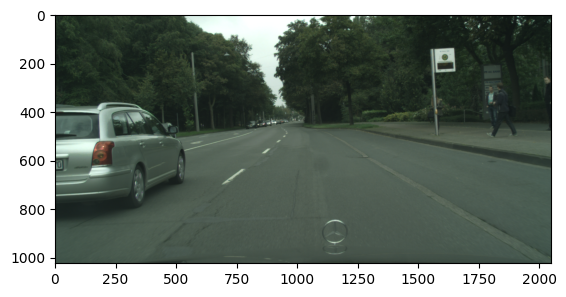

In [10]:
img, lbl = cityscapes_dataset[1]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [11]:
logits = get_logits(model, img).squeeze()

/home/user/anaconda3/envs/maskformer_env/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


Output Conv Pixel Decoder: (Min, Max, Mean, STD)  -0.135735422372818 0.12012837827205658 -5.8231667935615405e-05 0.02223283238708973
Y Output Pixel Decoder: (Min, Max, Mean, STD)  0.0 6.8848161697387695 0.37601542472839355 0.6439234018325806
Pixel Decoder Out Entry 0: (Min, Max, Mean, STD)  -5.240597248077393 4.581599712371826 0.001087206183001399 1.0569202899932861
Pixel Decoder Out Entry 1: (Min, Max, Mean, STD)  -4.541285514831543 4.503660678863525 0.0010746561456471682 1.0567578077316284
Pixel Decoder Out Entry 2: (Min, Max, Mean, STD)  -4.330517768859863 4.745089054107666 0.0014206215273588896 1.056318998336792
Pixel Decoder Out Entry 3: (Min, Max, Mean, STD)  0.0 6.8848161697387695 0.37601542472839355 0.6439234018325806
Mask Features Conv Layer: (Min, Max, Mean, STD)  -0.3296685218811035 0.3044293224811554 1.0069823474623263e-05 0.054454024881124496
Pixel Decoder Mask Features stats: (Min, Max, Mean, STD)  -4.666508197784424 4.924887657165527 0.01699983887374401 0.832444727420806